In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from multiprocessing import Pool
from lampe.data import JointLoader
from itertools import islice
from tqdm import tqdm
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_name = '23_03_21_final_posterior'      # File name 
data_dir = "../experiments/benchmark_hsp90/results/raw_data/"
plot_dir = "../experiments/benchmark_hsp90/results/plots/"
config_dir = "../experiments/benchmark_hsp90/"
num_samples_stats = 20000           # Number of simulations for computing posterior stats
num_samples_SBC = 10000             # Number of simulations for SBC
num_posterior_samples_SBC = 4096    # Number of posterior samples for each SBC simulation
num_samples_posterior = 50000       # Number of samples to draw from posterior
batch_size_sampling = 100           # Batch size for sampling posterior
num_workers = 24                    # Number of CPU cores
device = 'cuda'                     # Device for computations
save_data = True
save_figures = True

In [3]:
def posterior_std_mean(image_params, estimator):

    cryosbi = CryoEmSimulator(image_params)
    indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((num_samples_stats,))
    images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

    theta_samples = []
    with torch.no_grad():
        for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
            samples = estimator.sample(
                batched_images.cuda(non_blocking=True),
                shape=(num_samples_posterior,)
            ).cpu()
            theta_samples.append(
                samples.reshape(-1, batch_size_sampling)
            )
        samples = torch.cat(theta_samples, dim=1)

    mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
    posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
    confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

    return mean_distance, confidence_widths

## Load cryo-em simulator and posterior with correct config

In [4]:
cryosbi = CryoEmSimulator(config_dir + "image_params_training.json")

../data/protein_models/hsp90_models.npy


In [5]:
train_config = json.load(open(config_dir + "resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(config_dir + "posterior_hsp90.estimator"))
estimator.cuda()
estimator.eval();

## Testing posterior on single images

In [6]:
indices = torch.tensor(np.arange(0, cryosbi.max_index + 1, 1), dtype=float)
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [7]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(
            samples
        )
    samples = torch.cat(theta_samples, dim=1)

In [8]:
if save_data:
    torch.save(
        {
        "indices": indices,
        "images": images,
        "posterior_samples": samples
        },
        f'{data_dir}{file_name}_snr01_examples.pt'
    )

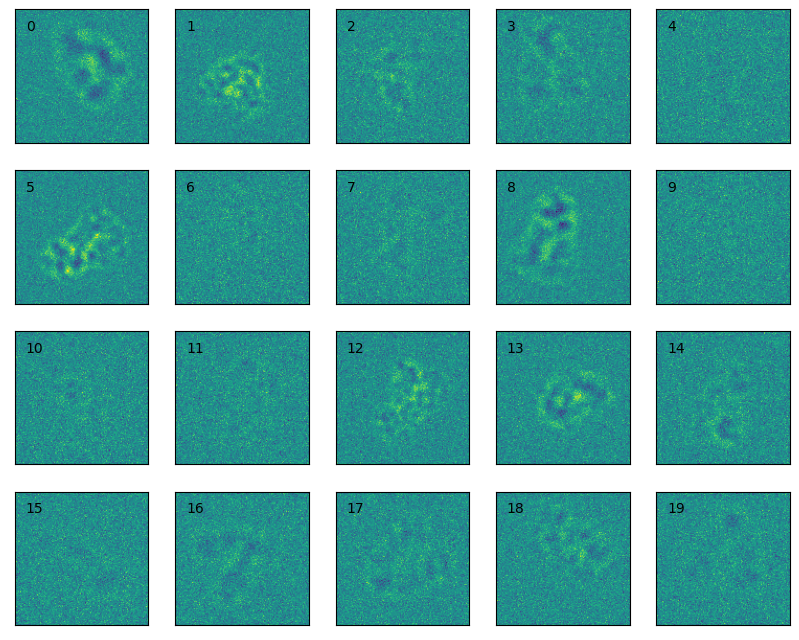

In [8]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx], vmax=5, vmin=-5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))

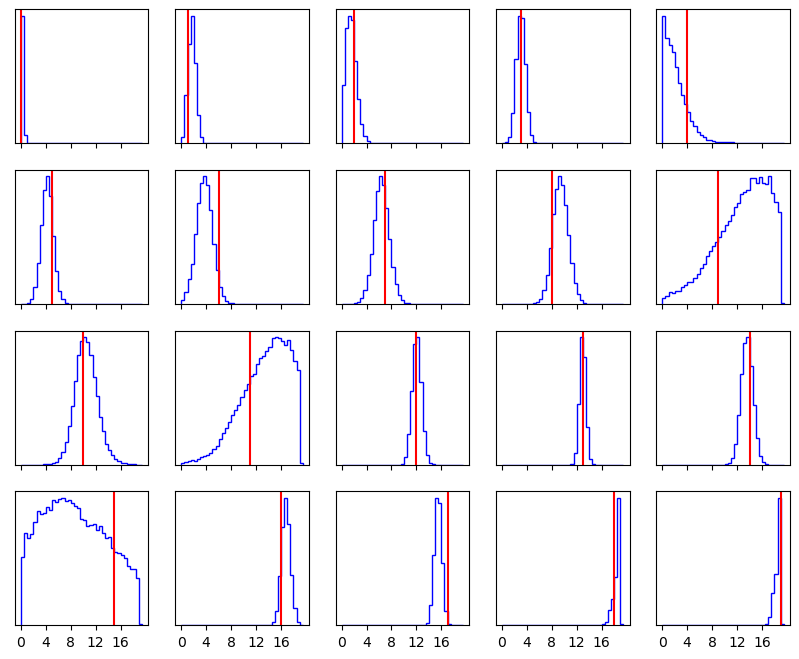

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(samples[:, idx].numpy(), bins=np.arange(0, 20, 0.5), histtype="step", color="blue", label="all")
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 20, 4))
    ax.axvline(indices[idx], color='red')

## Generate images from prior and evaluate posterior for statistical analysis

In [11]:
means_confidence_width = posterior_std_mean(f'{config_dir}image_params_training.json', estimator)
torch.save(means_confidence_width,f'{data_dir}{file_name}stats_training.pt')

../data/protein_models/hsp90_models.npy


KeyboardInterrupt: 

In [ ]:
for snr in np.logspace(np.log10(0.5), -2, 5):
    for defoc in np.linspace(0.5, 2, 4):
        means_confidence_width = posterior_std_mean(f'{config_dir}image_params_snr={round(snr, 2)}_defocus={defoc}.json', estimator)
        torch.save(means_confidence_width, f'{data_dir}{file_name}stats_snr={round(snr, 2)}_defocus={defoc}.pt')

In [ ]:
for i in range(0, 201, 20):

    file_name = f'posterior_hsp90.estimator_epoch={i}'
    if i == 200:
        file_name = f'posterior_hsp90.estimator'

    train_config = json.load(open(config_dir + "resnet18_encoder.json"))
    estimator = build_models.build_npe_flow_model(train_config)
    estimator.load_state_dict(torch.load(config_dir + file_name))
    estimator.cuda()
    estimator.eval()

    means_confidence_width = posterior_std_mean(f'{config_dir}image_params_snr={0.07}_defocus={1.5}.json', estimator)
    torch.save(means_confidence_width, f'{data_dir}{file_name}stats_round={i}.pt')

## Compute posterior calibration

In [ ]:
cryosbi = CryoEmSimulator(f"{config_dir}image_params_training.json")
for i in range(0, 201, 20):

    file_name = f'{config_dir}posterior_hsp90.estimator_epoch={i}'
    if i == 200:
        file_name = f'{config_dir}posterior_hsp90.estimator'

    train_config = json.load(open(config_dir + "resnet18_encoder.json"))
    estimator = build_models.build_npe_flow_model(train_config)
    estimator.load_state_dict(torch.load(config_dir + file_name))
    estimator.cuda()
    estimator.eval()

    loader = JointLoader(
        priors.get_uniform_prior_1d(cryosbi.max_index),
        cryosbi.simulator,
        vectorized=False,
        batch_size=1, 
        num_workers=num_workers,
        prefetch_factor=1
    )

    levels, coverages = expected_coverage_mc(
        estimator.flow,
        ((estimator.standardize(theta.cuda()), x.cuda()) for theta, x in islice(loader, 20000)),
        n = num_posterior_samples_SBC
    )

    torch.save([levels, coverages], f'{data_dir}{file_name}SBC_round={i}.pt')

## Generate images from index 10 with known quaternion

In [ ]:
cryosbi = CryoEmSimulator(config_dir + "image_params_snr=0.07_defocus=1.5.json")
quats = torch.from_numpy(np.load('quaternion_list.npy'))
indices = 10 * torch.ones(len(quats)).reshape(-1, 1)
images = torch.stack([cryosbi._simulator_with_quat(index, quat, seed=None) for index, quat in zip(indices, quats)], dim=0)

In [ ]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(
            samples.reshape(-1, batch_size_sampling)
        )
samples = torch.cat(theta_samples, dim=1)

In [ ]:
if save_data:
    torch.save(
        {
        'indices': indices,
        'images': images,
        'posterior_samples': samples
        },
        f"{data_dir}{file_name}_quats.pt"
    )